In [39]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from torch import device
import os
import matplotlib.pyplot as plt

In [34]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Constants
BATCH_SIZE = 25
NUM_EPOCHS = 200
LABEL_TO_CLASS: dict = {
    'N': 0,
    'D': 1,
    'G': 2,
    'C': 3,
    'A': 4,
    'H': 5,
    'M': 6,
    'O': 7
} 
NUM_CLASSES: int = len(LABEL_TO_CLASS)
DEVICE = device("cuda" if is_available() else "cpu")
LEARNING_RATE: float = 0.0002

In [37]:
# Define a SyntheticDataset class
class SyntheticDataset(Dataset):
    def __init__(self, root_dir, labels, transform=None):
        self.data = pd.read_csv(labels)
        self.root_dir = root_dir
        self.transform = transform
        self.label_mapping = {'N': 0,'D': 1,'G': 2,'C': 3,'A': 4,'H': 5,'M': 6,'O': 7}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)

        label = self.label_mapping[self.data.iloc[idx, 1]]

        if self.transform:
            image = self.transform(image)

        return image, label
    
# Define DataLoader for synthetic dataset
synthetic_dataset = SyntheticDataset(root_dir='../data/preprocessed_imgs_sub50', labels='../data/sub_odir_labels.csv', transform=transform)
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define image classification model
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(DEVICE)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
losses_per_epoch = []

# Training loop
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(synthetic_dataloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE).squeeze().long()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(synthetic_dataloader)
        losses_per_epoch.append(epoch_loss)
    
        if i % 15 == 14:  # Print every 7 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

/Users/sarahcasale/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sarahcasale/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1,    15] loss: 2.891
[2,    15] loss: 1.725
[3,    15] loss: 1.047
[4,    15] loss: 0.494
[5,    15] loss: 0.468
[6,    15] loss: 0.366
[7,    15] loss: 0.410
[8,    15] loss: 0.392
[9,    15] loss: 0.416
[10,    15] loss: 0.346
[11,    15] loss: 0.320
[12,    15] loss: 0.327
[13,    15] loss: 0.250
[14,    15] loss: 0.320
[15,    15] loss: 0.189
[16,    15] loss: 0.153
[17,    15] loss: 0.217
[18,    15] loss: 0.156
[19,    15] loss: 0.223
[20,    15] loss: 0.140
[21,    15] loss: 0.195
[22,    15] loss: 0.179
[23,    15] loss: 0.134
[24,    15] loss: 0.139
[25,    15] loss: 0.126
[26,    15] loss: 0.126
[27,    15] loss: 0.093
[28,    15] loss: 0.064
[29,    15] loss: 0.112
[30,    15] loss: 0.102
[31,    15] loss: 0.089
[32,    15] loss: 0.107
[33,    15] loss: 0.145
[34,    15] loss: 0.247
[35,    15] loss: 0.236
[36,    15] loss: 0.280
[37,    15] loss: 0.228
[38,    15] loss: 0.222
[39,    15] loss: 0.077
[40,    15] loss: 0.101
[41,    15] loss: 0.075
[42,    15] loss: 0.036
[

ValueError: x and y must have same first dimension, but have shapes (200,) and (3200,)

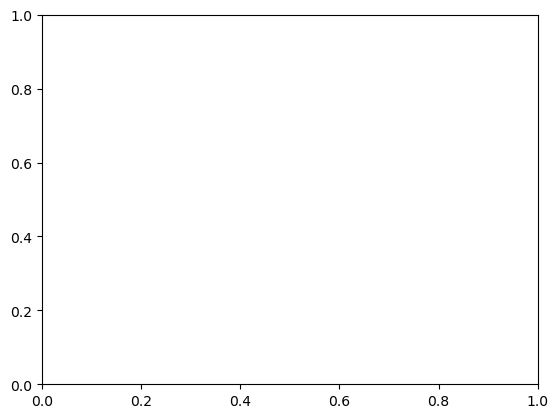

In [40]:
# Plotting the loss function
plt.plot(range(1, NUM_EPOCHS + 1), losses_per_epoch, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function over Epochs')
plt.grid(True)
plt.show()